In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as PLT
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, Model,Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import os,glob,random,shutil
from pathlib import Path
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import pickle

In [4]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Define required paths
# data_path = 'Datasets/Scene/data'
# train_test_path = 'Datasets/Scene/train_test'
# train_path = 'Datasets/Scene/train_test/train'
# test_path = 'Datasets/Scene/train_test/test'
# model_path='Datasets/Scene/model'
data_path = os.path.join('__file__', '../../../../datasets/Caltech256/data/')
train_test_path = os.path.join('__file__', '../../../../datasets/Caltech256/train_test/')
train_path = os.path.join(train_test_path, 'train/')
test_path = os.path.join(train_test_path, 'test/')

In [7]:
# Create Train and Test set randomly per class in different directories
train_count = 100

if os.path.isdir(train_test_path):
    shutil.rmtree(train_test_path)
Path(f'{train_test_path}').mkdir(parents=True, exist_ok=True)

for category in os.listdir(data_path):
    images = glob.glob(f'{data_path}/{category}/*')
    random.shuffle(images)
    
    # Train data
    Path(f'{train_path}/{category}/').mkdir(parents=True, exist_ok=True)
    
    for img in images[:train_count]:
        shutil.copyfile(img, f'{train_path}/{category}/'+img.split("\\")[-1])
        
    # Test data
    Path(f'{test_path}/{category}/').mkdir(parents=True, exist_ok=True)
    for img in images[train_count:]:
        shutil.copyfile(img, f'{test_path}/{category}/'+img.split("\\")[-1])     

In [13]:
# Load the Training and Testing data
image_generator = ImageDataGenerator(
    rescale=1.0/255.0
)
batch_size = 100

generator = image_generator.flow_from_directory(
    train_path,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

generator_test = image_generator.flow_from_directory(
    test_path,
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(150,150)
)

Found 24447 images belonging to 257 classes.
Found 6160 images belonging to 257 classes.


 # Model1

In [14]:
# 5-layer CNN model1 with default learning rate (lr=0.001) and Adam optimizer

# Define the model1
model = Sequential([ 
    
    Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(64, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(128, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    Conv2D(256, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(512, 3, strides=1, activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(257, activation='softmax')
])

# Compile the model1
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model1
history = model.fit(
    generator,
    validation_data=generator_test,
    epochs=20,
    batch_size=32
)

Epoch 1/20
245/245 [==============================] - 48s 188ms/step - loss: 5.4555 - accuracy: 0.0208 - val_loss: 5.3686 - val_accuracy: 0.0242
Epoch 2/20
245/245 [==============================] - 44s 181ms/step - loss: 5.0282 - accuracy: 0.0546 - val_loss: 4.5250 - val_accuracy: 0.1612
Epoch 3/20
245/245 [==============================] - 45s 183ms/step - loss: 4.5713 - accuracy: 0.1011 - val_loss: 3.9423 - val_accuracy: 0.2552
Epoch 4/20
245/245 [==============================] - 45s 183ms/step - loss: 4.1688 - accuracy: 0.1499 - val_loss: 4.1354 - val_accuracy: 0.2265
Epoch 5/20
245/245 [==============================] - 45s 183ms/step - loss: 3.8174 - accuracy: 0.1936 - val_loss: 3.5916 - val_accuracy: 0.2862
Epoch 6/20
245/245 [==============================] - 44s 181ms/step - loss: 3.4854 - accuracy: 0.2447 - val_loss: 3.2724 - val_accuracy: 0.3407
Epoch 7/20
245/245 [==============================] - 45s 182ms/step - loss: 3.1383 - accuracy: 0.2977 - val_loss: 3.1541 - val_ac

In [17]:
# Pickle the history object
with open('caltech256/history.pickle', 'wb') as f:
    pickle.dump(history.history, f)
# Save the model1    
model.save('caltech256/model1')
model.summary()

INFO:tensorflow:Assets written to: caltech256/model1/assets


INFO:tensorflow:Assets written to: caltech256/model1/assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 73, 73, 64)       256       
 chNormalization)                                                
                                                      

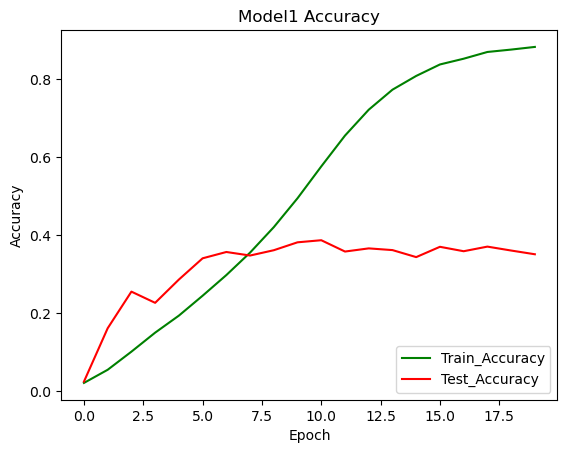

In [21]:
# Plot the model1
PLT.plot(history.history['accuracy'],color='green')
PLT.plot(history.history['val_accuracy'],color='red')
PLT.title('Model1 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()

# Model2 

In [24]:
# 6-layer CNN model2 with default learning rate (lr=0.001) and Adam optimizer

# Define the model2
model = Sequential([
  
    Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3)),
    Conv2D(32, 3, strides=1, activation='relu', padding='same'), 
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Conv2D(64, 3, strides=1, activation='relu'),
    Conv2D(64, 3, strides=1, activation='relu'),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
       
    Conv2D(64, 3, strides=1, activation='relu'),
    Conv2D(64, 3, strides=1, activation='relu'),
    MaxPool2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    
    Flatten(),
    Dense(257, activation='softmax')
])

# Compile the model2
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train the model2
history1 = model.fit(
    generator,
    validation_data=generator_test,
    epochs=20,
    batch_size=32
)

Epoch 1/20


2023-02-25 22:22:13.658211: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-02-25 22:22:14.672760: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-25 22:22:14.672781: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-25 22:22:14.914560: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying 

245/245 [==============================] - 68s 271ms/step - loss: 5.7423 - accuracy: 0.0261 - val_loss: 5.3541 - val_accuracy: 0.0729
Epoch 2/20
245/245 [==============================] - 67s 273ms/step - loss: 4.7442 - accuracy: 0.0947 - val_loss: 4.4175 - val_accuracy: 0.1805
Epoch 3/20
245/245 [==============================] - 80s 327ms/step - loss: 4.2199 - accuracy: 0.1643 - val_loss: 3.6503 - val_accuracy: 0.3057
Epoch 4/20
245/245 [==============================] - 70s 285ms/step - loss: 3.7465 - accuracy: 0.2278 - val_loss: 3.5818 - val_accuracy: 0.3261
Epoch 5/20
245/245 [==============================] - 71s 289ms/step - loss: 3.2767 - accuracy: 0.2933 - val_loss: 3.5853 - val_accuracy: 0.3305
Epoch 6/20
245/245 [==============================] - 68s 276ms/step - loss: 2.7708 - accuracy: 0.3779 - val_loss: 3.8700 - val_accuracy: 0.3200
Epoch 7/20
245/245 [==============================] - 67s 275ms/step - loss: 2.2624 - accuracy: 0.4641 - val_loss: 4.6566 - val_accuracy: 0.2

In [26]:
# Pickle the history object
with open('caltech256/history1.pickle', 'wb') as f:
    pickle.dump(history1.history, f)
# Save the model2
model.save('caltech256/model2')
model.summary()

INFO:tensorflow:Assets written to: caltech256/model2/assets


INFO:tensorflow:Assets written to: caltech256/model2/assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 conv2d_22 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Bat  (None, 75, 75, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 73, 73, 64)       

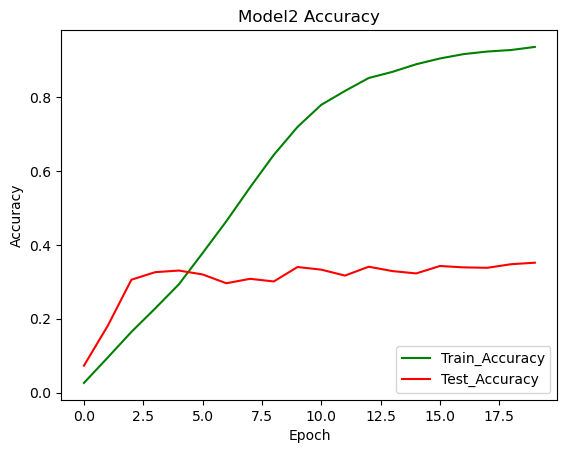

In [27]:
# Plot the model2
PLT.plot(history1.history['accuracy'],color='green')
PLT.plot(history1.history['val_accuracy'],color='red')
PLT.title('Model2 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()

# Model3

In [30]:
## 5-layer CNN model3 with different learning rates for different convolutional layers and Adam optimizer

# Define the learning rate schedule
boundaries = [5, 10, 15, 20] # Epochs at which to change the learning rate
values = [1e-2,1e-3, 1e-4, 1e-5,1e-6] # Learning rates for each boundary
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Define the model3
model = Sequential([
     
Conv2D(32, 3, strides=1, activation='relu', padding='same',input_shape=(150,150,3),name='conv1'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    Conv2D(64, 3, strides=1, activation='relu',name='conv2'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    
    Conv2D(128, 3, strides=1, activation='relu',name='conv3'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    
    
    Conv2D(256, 3, strides=1, activation='relu',name='conv4'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    
    Conv2D(512, 3, strides=1, activation='relu',name='conv5'),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
     
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(257, activation='softmax')
])

# Define the optimizer with different learning rates for each convolutional layer
opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate_fn)
model.get_layer('conv1').optimizer = tf.keras.optimizers.Adam(learning_rate=values[0])
model.get_layer('conv2').optimizer = tf.keras.optimizers.Adam(learning_rate=values[1])
model.get_layer('conv3').optimizer = tf.keras.optimizers.Adam(learning_rate=values[2])
model.get_layer('conv4').optimizer = tf.keras.optimizers.Adam(learning_rate=values[3])
model.get_layer('conv5').optimizer = tf.keras.optimizers.Adam(learning_rate=values[4])

# Compile the model3
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model3
history2 = model.fit(
    generator,
    validation_data=generator_test,
    epochs=20,
)

Epoch 1/20
245/245 [==============================] - 57s 230ms/step - loss: 5.7383 - accuracy: 0.0042 - val_loss: 5.5454 - val_accuracy: 0.0044
Epoch 2/20
245/245 [==============================] - 60s 244ms/step - loss: 5.6767 - accuracy: 0.0046 - val_loss: 5.5468 - val_accuracy: 0.0052
Epoch 3/20
245/245 [==============================] - 47s 189ms/step - loss: 5.6567 - accuracy: 0.0043 - val_loss: 5.5468 - val_accuracy: 0.0054
Epoch 4/20
245/245 [==============================] - 43s 175ms/step - loss: 5.6436 - accuracy: 0.0041 - val_loss: 5.5424 - val_accuracy: 0.0049
Epoch 5/20
245/245 [==============================] - 43s 174ms/step - loss: 5.6295 - accuracy: 0.0041 - val_loss: 5.5387 - val_accuracy: 0.0055
Epoch 6/20
245/245 [==============================] - 42s 172ms/step - loss: 5.6211 - accuracy: 0.0040 - val_loss: 5.5364 - val_accuracy: 0.0050
Epoch 7/20
245/245 [==============================] - 42s 171ms/step - loss: 5.6127 - accuracy: 0.0038 - val_loss: 5.5353 - val_ac

In [32]:
# Pickle the history object
with open('caltech256/history2.pickle', 'wb') as f:
    pickle.dump(history2.history, f)
# save the model3    
model.save('caltech256/model3')
model.summary()

INFO:tensorflow:Assets written to: caltech256/model3/assets


INFO:tensorflow:Assets written to: caltech256/model3/assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_26 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2 (Conv2D)              (None, 73, 73, 64)        18496     
                                                                 
 batch_normalization_27 (Bat  (None, 73, 73, 64)       256       
 chNormalization)                                                
                                                      

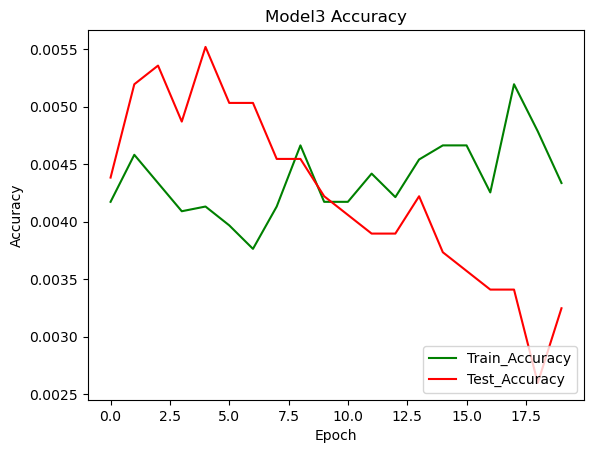

In [33]:
# Plot the model3
PLT.plot(history2.history['accuracy'],color='green')
PLT.plot(history2.history['val_accuracy'],color='red')
PLT.title('Model3 Accuracy')
PLT.ylabel('Accuracy')
PLT.xlabel('Epoch')
PLT.legend(['Train_Accuracy','Test_Accuracy'], loc='lower right')
PLT.show()